In [64]:
# Установка модулей
!pip install -q -U navec 
!pip install -q -U slovnet
!pip install -q -U openpyxl
!pip install -q -U TorchCRF

In [132]:
# Импорт библиотек
import re
import os
import warnings

from tqdm import tqdm
from collections import defaultdict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from navec import Navec
from slovnet.model.emb import NavecEmbedding

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from TorchCRF import CRF

import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/abdulrasidmukuev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
# Скачиваем исходный файл с вакансиями
raw_df = pd.read_excel("data.xlsx", dtype="str")
raw_df.tail()

,id,description,skills_str
16995,98b5bd15-d1f6-11ec-8c63-57fc951f3846,NaN,"Исполнительность, Ответственность, Разработка ..."
16996,b715d743-dea9-11e6-853f-bf2cfe8c828d,NaN,"машиностроение, ремонт судовых механизмов, раз..."
16997,5d3d8182-80a2-11e9-8ba1-bf2cfe8c828d,NaN,"Фрезеровка, Работа в тисках, Обработка деталей..."
16998,a2d50a52-ab22-11ea-94f4-bf2cfe8c828d,NaN,"соблюдение норм, внутренний трудовой распорядо..."
16999,8d0b6c02-cb11-11ea-94f4-bf2cfe8c828d,NaN,"знание правил ручной резки, работа с одеждой и..."


In [28]:
# Избавляемся от вакансий с пропусками
df = raw_df.dropna(subset="description")
df.tail()

,id,description,skills_str
16916,31220962,Обязанности: Верстка и дизайн рекламной прод...,"Верстка, Дизайн, Разработка логотипов, Предпеч..."
16917,31285209,Обязанности: - проведение переговоров с предст...,"переговоры с организациями, разработка меропри..."
16918,40252884,"Обязанности: Управление группой продукции, ра...","управление продукцией, анализ потребностей кли..."
16919,23978165,"Обязанности: работа с сетевыми магазинами, по...","работа с сетевыми магазинами, выкладка продукц..."
16920,37498527,Обязанности: Поиск потенциальных клиентов по ...,"Поиск клиентов, Ведение клиента, Участие в тен..."


In [29]:
# Функция для BIO-разметки слов-токенов
def create_bio_tagged_data(id, description, skills_str):
    # Токенизация списка навыков
    skills = [skill.strip() for skill in str(skills_str).split(',')]
    skills_tokens = [word_tokenize(skill.lower()) for skill in skills]
    
    # Токенизация описания вакансии
    description_tokens = word_tokenize(description.lower())
    
    # Создание списка для итоговых данных
    data = []
    
    i = 0
    while i < len(description_tokens):
        token = description_tokens[i]
        tag = 'O'  # По умолчанию каждый токен не является навыком
        
        for skill_tokens in skills_tokens:
            if description_tokens[i:i+len(skill_tokens)] == skill_tokens:
                tag = 'B-SKILL'
                data.append((id, token, tag))
                for j in range(1, len(skill_tokens)):
                    i += 1
                    token = description_tokens[i]
                    tag = 'I-SKILL'
                    data.append((id, token, tag))
                break  # Прерываем цикл, так как совпадение найдено
                
        if tag == 'O':  # Если токен не был отмечен как часть навыка
            data.append((id, token, tag))
        i += 1
    
    return pd.DataFrame(data, columns=['id', 'token', 'tag'])

# Функция для применения BIO-разметки
def apply_to_row(row):
    return create_bio_tagged_data(row['id'], row['description'], row['skills_str'])

In [30]:
# Преобразуем датафрейм в BIO-нотацию
tagged_dataframes = [apply_to_row(row) for index, row in df.iterrows()]
result_df = pd.concat(tagged_dataframes).reset_index(drop=True)
result_df.tail()

,id,token,tag
1985222,37498527,10:00-18:00,O
1985223,37498527,лояльное,O
1985224,37498527,и,O
1985225,37498527,грамотное,O
1985226,37498527,руководство,O


In [38]:
# Сохраним result_df на будущее
result_df.to_csv("data_bio.csv", encoding="utf-16", index=False)

In [110]:
# Скачиваем result_df
result_df = pd.read_csv("data_bio.csv", encoding="utf-16")
result_df

,id,token,tag
0,16123526,обязанности,O
1,16123526,:,O
2,16123526,перевод,O
3,16123526,технической,O
4,16123526,документации,O
...,...,...,...
1985222,37498527,10:00-18:00,O
1985223,37498527,лояльное,O
1985224,37498527,и,O
1985225,37498527,грамотное,O


In [111]:
# Получаем уникальные идентификаторы вакансий
unique_ids = result_df['id'].unique()

# Разделяем идентификаторы вакансий на тренировочную, валидационную и тестовую группы
train_ids, temp_ids = train_test_split(unique_ids, test_size=2959, random_state=42) # 2959 это сумма 1500 и 1459
val_ids, test_ids = train_test_split(temp_ids, test_size=1459, random_state=42) # Разделяем оставшиеся на валидационные и тестовые

# Теперь разделяем исходный датафрейм на тренировочную, валидационную и тестовую выборки, используя полученные идентификаторы
train_df = result_df[result_df['id'].isin(train_ids)]
val_df = result_df[result_df['id'].isin(val_ids)]
test_df = result_df[result_df['id'].isin(test_ids)]

# Проверяем размерность данных
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 1447011
Validation size: 271767
Test size: 266449


In [112]:
# Функция для базовой оценки 
def calculate_baseline_accuracy(df):
    # Считаем, сколько раз тег совпал с "O"
    correct_predictions = df['tag'].value_counts().get('O', 0)
    # Общее количество предсказаний
    total_predictions = len(df)
    # Вычисляем точность
    accuracy = correct_predictions / total_predictions
    return accuracy

# Вычисляем точность для тренировочной, валидационной и тестовой выборок
print(f"Accuracy on training data: {calculate_baseline_accuracy(train_df):.4f}")
print(f"Accuracy on validation data: {calculate_baseline_accuracy(val_df):.4f}")
print(f"Accuracy on test data: {calculate_baseline_accuracy(test_df):.4f}")

Accuracy on training data: 0.9677
Accuracy on validation data: 0.9696
Accuracy on test data: 0.9642


* Как можно заметить, большая часть токенов не имеет тега, что свойственно для NER. Исходя из этого, использовать обобщенную метрику качества accuracy может быть нецелесообразно. Вместо нее будем использовать precision, recall и f-меру с микро- и макро-усреднением для многоклассовой классификации.

In [121]:
# Загружаем эмбеддинги
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'  # 51MB
navec = Navec.load(path)  # ~1 sec, ~100MB RAM
emb = NavecEmbedding(navec)

print(torch.tensor(navec.vocab['собака']))
print(torch.tensor(navec.pq[navec.vocab['собака']])[:10])

tensor(406682)
tensor([-0.5378, -0.6289, -0.3964, -0.3829, -0.6061, -0.6350,  0.4124,  0.3353,
         0.4763, -0.6062])


In [122]:
# Преобразуем токены в эмбеддинги
grouped_train = train_df['id'].unique()
grouped_val = val_df['id'].unique()
grouped_test = test_df['id'].unique()

sentence_embeddings_train = []
sentence_embeddings_val = []
sentence_embeddings_test = []

for sentence in tqdm(grouped_train):
    sentence_words = list(train_df[train_df["id"] == sentence]["token"])
    embeddings = [torch.tensor(navec.get(token, navec['<unk>'])) for token in sentence_words]
    embeddings_tensors = torch.stack(embeddings)
    sentence_embeddings_train.append(embeddings_tensors)

for sentence in tqdm(grouped_val):
    sentence_words = list(val_df[val_df["id"] == sentence]["token"])
    embeddings = [torch.tensor(navec.get(token, navec['<unk>'])) for token in sentence_words]
    embeddings_tensors = torch.stack(embeddings)
    sentence_embeddings_val.append(embeddings_tensors)

for sentence in tqdm(grouped_test):
    sentence_words = list(test_df[test_df["id"] == sentence]["token"])
    embeddings = [torch.tensor(navec.get(token, navec['<unk>'])) for token in sentence_words]
    embeddings_tensors = torch.stack(embeddings)
    sentence_embeddings_test.append(embeddings_tensors)

100%|██████████| 1459/1459 [00:02<00:00, 499.01it/s]


In [123]:
# Осуществляем паддинг для нормализации размерностей эмбеддингов
padded_embeddings_train = pad_sequence(sentence_embeddings_train, batch_first=True)
padded_embeddings_val = pad_sequence(sentence_embeddings_val, batch_first=True)
padded_embeddings_test = pad_sequence(sentence_embeddings_test, batch_first=True)

print(padded_embeddings_train.shape)
print(padded_embeddings_val.shape)
print(padded_embeddings_test.shape)

torch.Size([8000, 1480, 300])
torch.Size([1500, 1083, 300])
torch.Size([1459, 964, 300])


In [124]:
# Создаем словарь тегов
tag_to_idx = {tag: i for i, tag in enumerate(result_df['tag'].unique())}

# Добавляем тег отсутствия
if "<pad>" not in tag_to_idx:
    tag_to_idx["<pad>"] = len(tag_to_idx)  

# Преобразуем теги в тензоры
grouped_train = train_df['id'].unique()
grouped_val = val_df['id'].unique()
grouped_test = test_df['id'].unique()

tags_sequences_train = []
tags_sequences_val = []
tags_sequences_test = []

for sentence in tqdm(grouped_train):
    sentence_tags = list(train_df[train_df["id"] == sentence]["tag"])
    tags_idx = [tag_to_idx[tag] for tag in sentence_tags]
    tags_tensor = torch.tensor(tags_idx, dtype=torch.long)
    tags_sequences_train.append(tags_tensor)

for sentence in tqdm(grouped_val):
    sentence_tags = list(val_df[val_df["id"] == sentence]["tag"])
    tags_idx = [tag_to_idx[tag] for tag in sentence_tags]
    tags_tensor = torch.tensor(tags_idx, dtype=torch.long)
    tags_sequences_val.append(tags_tensor)

for sentence in tqdm(grouped_test):
    sentence_tags = list(test_df[test_df["id"] == sentence]["tag"])
    tags_idx = [tag_to_idx[tag] for tag in sentence_tags]
    tags_tensor = torch.tensor(tags_idx, dtype=torch.long)
    tags_sequences_test.append(tags_tensor)

# Нормализуем теги
padded_tags_train = pad_sequence(tags_sequences_train, batch_first=True, padding_value=tag_to_idx["<pad>"])
padded_tags_val = pad_sequence(tags_sequences_val, batch_first=True, padding_value=tag_to_idx["<pad>"])
padded_tags_test = pad_sequence(tags_sequences_test, batch_first=True, padding_value=tag_to_idx["<pad>"])

print(padded_tags_train.shape)
print(padded_tags_val.shape)
print(padded_tags_test.shape)

100%|██████████| 1459/1459 [00:00<00:00, 4234.86it/s]

torch.Size([8000, 1480])
torch.Size([1500, 1083])
torch.Size([1459, 964])


In [125]:
class NERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(NERModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        tag_space = self.fc(lstm_out.reshape(-1, lstm_out.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores.reshape(x.shape[0], x.shape[1], -1)

In [126]:
# Создаем структуру для подачи в модель
dataset_train = TensorDataset(padded_embeddings_train, padded_tags_train)
dataset_val = TensorDataset(padded_embeddings_val, padded_tags_val)
dataset_test = TensorDataset(padded_embeddings_test, padded_tags_test)

# Создание DataLoader'ов для тренировочного и валидационного наборов
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32)
test_loader = DataLoader(dataset_test, batch_size=32)

In [127]:
# Определяем метрики precision, recall, F1
def calculate_metrics(predictions, true_tags, skill_tag_indices):
    """
    Расчет precision, recall и F1-score только для тегов B-SKILL и I-SKILL.
    
    predictions: Предсказания модели (после применения torch.max).
    true_tags: Истинные теги.
    skill_tag_indices: Индексы тегов B-SKILL и I-SKILL.
    """
    # Инициализация счетчиков для TP, FP, FN
    tp = 0
    fp = 0
    fn = 0

    # Преобразование векторов для удобства сравнения
    pred_flat = predictions.view(-1)
    true_flat = true_tags.view(-1)
    
    for skill_tag in skill_tag_indices:
        # True Positives: Предсказанный тег совпадает с истинным
        tp += ((pred_flat == skill_tag) & (true_flat == skill_tag)).sum().item()
        # False Positives: Предсказан тег, но истинный тег другой
        fp += ((pred_flat == skill_tag) & (true_flat != skill_tag)).sum().item()
        # False Negatives: Тег не был предсказан, хотя он есть
        fn += ((pred_flat != skill_tag) & (true_flat == skill_tag)).sum().item()

    # Расчет метрик
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1

In [128]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([1.0, 100.0, 100.0, 1.0])  # Пример весов для классов: O, B-SKILL, I-SKILL и null

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch)
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch)
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.3101, Val Loss: 0.2296, Precision: 0.0754, Recall: 0.8619, F1: 0.1382
Epoch 2, Train Loss: 0.1894, Val Loss: 0.2079, Precision: 0.0803, Recall: 0.8780, F1: 0.1466
Epoch 3, Train Loss: 0.1727, Val Loss: 0.2012, Precision: 0.0919, Recall: 0.8754, F1: 0.1655
Epoch 4, Train Loss: 0.1628, Val Loss: 0.1927, Precision: 0.1085, Recall: 0.8667, F1: 0.1920
Epoch 5, Train Loss: 0.1535, Val Loss: 0.1888, Precision: 0.0947, Recall: 0.8862, F1: 0.1702
Epoch 6, Train Loss: 0.1466, Val Loss: 0.1906, Precision: 0.0951, Recall: 0.8829, F1: 0.1709
Epoch 7, Train Loss: 0.1411, Val Loss: 0.1918, Precision: 0.1144, Recall: 0.8670, F1: 0.2008
Epoch 8, Train Loss: 0.1330, Val Loss: 0.1890, Precision: 0.1136, Recall: 0.8770, F1: 0.2001
Epoch 9, Train Loss: 0.1318, Val Loss: 0.2069, Precision: 0.0745, Recall: 0.8925, F1: 0.1366
Epoch 10, Train Loss: 0.1219, Val Loss: 0.1905, Precision: 0.1036, Recall: 0.8834, F1: 0.1845


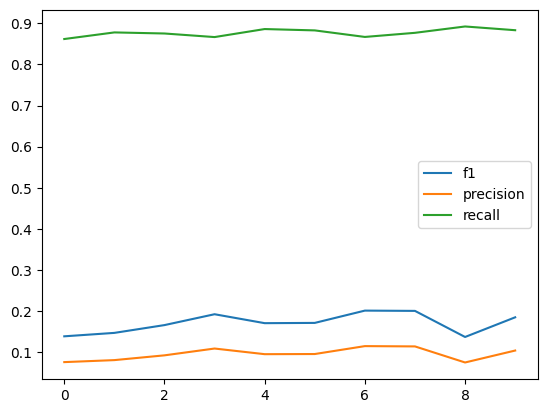

In [137]:
sns.lineplot(x = range(num_epochs), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(num_epochs), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(num_epochs), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

* Мы достигли максимума точности уже на 6 эапохе, получив precision 18.9%, recall 75.5% и f1 30.0%. Попробуем усложить модель, добавив больше слоев.

In [138]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([1.0, 20.0, 20.0, 1.0])  # Пример весов для классов: O, B-SKILL, I-SKILL и null

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 7

avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch)
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch)
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.1950, Val Loss: 0.1350, Precision: 0.1653, Recall: 0.6229, F1: 0.2592
Epoch 2, Train Loss: 0.1002, Val Loss: 0.1159, Precision: 0.1628, Recall: 0.7207, F1: 0.2639
Epoch 3, Train Loss: 0.0911, Val Loss: 0.1117, Precision: 0.1479, Recall: 0.7828, F1: 0.2473
Epoch 4, Train Loss: 0.0857, Val Loss: 0.1064, Precision: 0.1638, Recall: 0.7697, F1: 0.2687
Epoch 5, Train Loss: 0.0821, Val Loss: 0.1060, Precision: 0.1983, Recall: 0.7198, F1: 0.3090
Epoch 6, Train Loss: 0.0797, Val Loss: 0.1025, Precision: 0.1681, Recall: 0.7842, F1: 0.2755
Epoch 7, Train Loss: 0.0762, Val Loss: 0.0988, Precision: 0.1684, Recall: 0.7927, F1: 0.2762


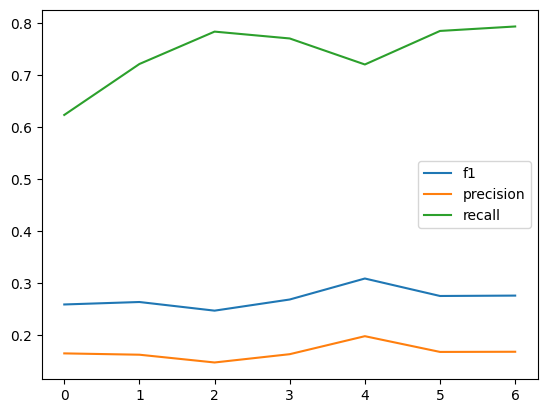

In [139]:
sns.lineplot(x = range(num_epochs), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(num_epochs), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(num_epochs), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [140]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([1.0, 5.0, 5.0, 1.0])  # Пример весов для классов: O, B-SKILL, I-SKILL и null

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 7

avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch)
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch)
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.1404, Val Loss: 0.0667, Precision: 0.3132, Recall: 0.2149, F1: 0.2506
Epoch 2, Train Loss: 0.0477, Val Loss: 0.0561, Precision: 0.2980, Recall: 0.3698, F1: 0.3264
Epoch 3, Train Loss: 0.0424, Val Loss: 0.0518, Precision: 0.3182, Recall: 0.4247, F1: 0.3607
Epoch 4, Train Loss: 0.0398, Val Loss: 0.0511, Precision: 0.2801, Recall: 0.5602, F1: 0.3704
Epoch 5, Train Loss: 0.0378, Val Loss: 0.0479, Precision: 0.3181, Recall: 0.5123, F1: 0.3893
Epoch 6, Train Loss: 0.0364, Val Loss: 0.0471, Precision: 0.2962, Recall: 0.5596, F1: 0.3843
Epoch 7, Train Loss: 0.0356, Val Loss: 0.0460, Precision: 0.3407, Recall: 0.5003, F1: 0.4015


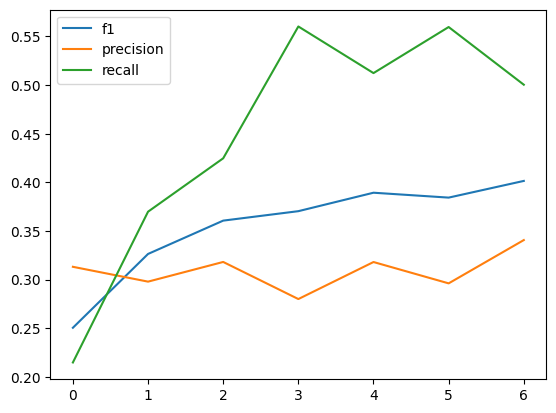

In [141]:
sns.lineplot(x = range(num_epochs), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(num_epochs), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(num_epochs), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [144]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([1.0, 2.0, 2.0, 1.0])  # Пример весов для классов: O, B-SKILL, I-SKILL и null

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch)
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch)
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.1151, Val Loss: 0.0434, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 2, Train Loss: 0.0299, Val Loss: 0.0364, Precision: 0.4397, Recall: 0.0869, F1: 0.1434
Epoch 3, Train Loss: 0.0260, Val Loss: 0.0315, Precision: 0.5082, Recall: 0.1314, F1: 0.2063
Epoch 4, Train Loss: 0.0238, Val Loss: 0.0295, Precision: 0.4744, Recall: 0.1825, F1: 0.2605
Epoch 5, Train Loss: 0.0226, Val Loss: 0.0311, Precision: 0.3668, Recall: 0.3640, F1: 0.3615
Epoch 6, Train Loss: 0.0218, Val Loss: 0.0275, Precision: 0.4657, Recall: 0.2729, F1: 0.3400
Epoch 7, Train Loss: 0.0210, Val Loss: 0.0267, Precision: 0.4841, Recall: 0.2625, F1: 0.3364
Epoch 8, Train Loss: 0.0205, Val Loss: 0.0263, Precision: 0.4872, Recall: 0.2720, F1: 0.3446
Epoch 9, Train Loss: 0.0199, Val Loss: 0.0258, Precision: 0.4745, Recall: 0.3005, F1: 0.3645
Epoch 10, Train Loss: 0.0194, Val Loss: 0.0255, Precision: 0.4611, Recall: 0.3403, F1: 0.3869


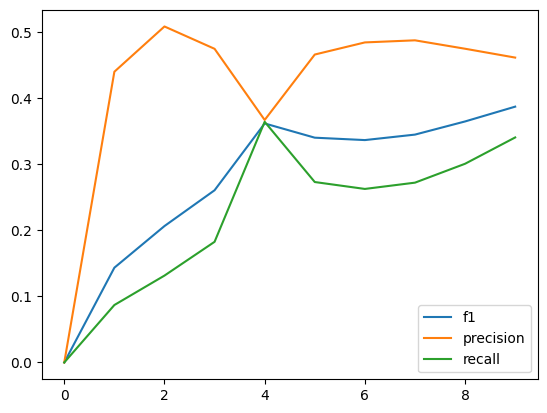

In [145]:
sns.lineplot(x = range(num_epochs), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(num_epochs), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(num_epochs), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [146]:
class NERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(NERModel, self).__init__()
        # Параметры для CNN
        self.num_filters = 50
        self.kernel_size = 3  # Размер ядра для сверточного слоя
        
        # Сверточный слой
        self.conv = nn.Conv1d(in_channels=embedding_dim,
                              out_channels=self.num_filters,
                              kernel_size=self.kernel_size,
                              padding=self.kernel_size // 2)  # padding для сохранения длины последовательности
        
        # Рекуррентный слой LSTM
        self.lstm = nn.LSTM(self.num_filters, hidden_dim // 2,
                            num_layers=num_layers, batch_first=True,
                            bidirectional=True, dropout=0.5)
        
        # Полносвязный слой для классификации
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x.shape = (batch_size, seq_length, embedding_dim)
        # Переставляем размерности для работы сверточного слоя
        x = x.permute(0, 2, 1)  # x.shape = (batch_size, embedding_dim, seq_length)
        
        # Применяем сверточный слой
        x = F.relu(self.conv(x))  # x.shape = (batch_size, num_filters, seq_length)
        
        # Возвращаем размерности для работы LSTM
        x = x.permute(0, 2, 1)  # x.shape = (batch_size, seq_length, num_filters)
        
        # Применяем LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out.shape = (batch_size, seq_length, hidden_dim)
        
        # Преобразуем данные для полносвязного слоя
        tag_space = self.fc(lstm_out.reshape(-1, lstm_out.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        
        # Возвращаем размерности в исходное состояние
        return tag_scores.reshape(x.shape[0], x.shape[1], -1)


In [147]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([1.0, 2.0, 2.0, 1.0])  # Пример весов для классов: O, B-SKILL, I-SKILL и null

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

avg_val_loss_lst = []
avg_precision_lst = []
avg_recall_lst = []
avg_f1_lst = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch)
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch)
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_loss_lst.append(avg_val_loss)

    avg_precision = sum(precision_list) / len(precision_list)
    avg_precision_lst.append(avg_precision)

    avg_recall = sum(recall_list) / len(recall_list)
    avg_recall_lst.append(avg_recall)

    avg_f1 = sum(f1_list) / len(f1_list)
    avg_f1_lst.append(avg_f1)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.1314, Val Loss: 0.0326, Precision: 0.5137, Recall: 0.0143, F1: 0.0275
Epoch 2, Train Loss: 0.0237, Val Loss: 0.0294, Precision: 0.3897, Recall: 0.2830, F1: 0.3214
Epoch 3, Train Loss: 0.0219, Val Loss: 0.0270, Precision: 0.4742, Recall: 0.2596, F1: 0.3315
Epoch 4, Train Loss: 0.0207, Val Loss: 0.0262, Precision: 0.4595, Recall: 0.3278, F1: 0.3780
Epoch 5, Train Loss: 0.0200, Val Loss: 0.0254, Precision: 0.4543, Recall: 0.3476, F1: 0.3884
Epoch 6, Train Loss: 0.0193, Val Loss: 0.0252, Precision: 0.4642, Recall: 0.3621, F1: 0.4025
Epoch 7, Train Loss: 0.0189, Val Loss: 0.0248, Precision: 0.5634, Recall: 0.2717, F1: 0.3627
Epoch 8, Train Loss: 0.0185, Val Loss: 0.0246, Precision: 0.4745, Recall: 0.3780, F1: 0.4173
Epoch 9, Train Loss: 0.0182, Val Loss: 0.0275, Precision: 0.3812, Recall: 0.4943, F1: 0.4267
Epoch 10, Train Loss: 0.0178, Val Loss: 0.0244, Precision: 0.5618, Recall: 0.2986, F1: 0.3860


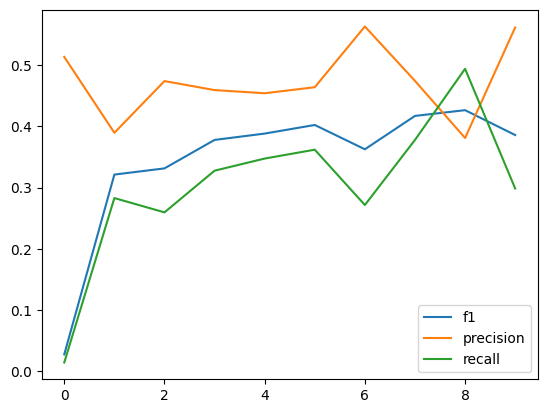

In [148]:
sns.lineplot(x = range(num_epochs), y = avg_f1_lst, label="f1")
sns.lineplot(x = range(num_epochs), y = avg_precision_lst, label="precision")
sns.lineplot(x = range(num_epochs), y = avg_recall_lst, label="recall")
plt.legend()
plt.show()

In [96]:
# Создаем словарь символов
def build_char_vocab(dataframe):
    char_vocab = defaultdict(lambda: len(char_vocab))
    char_vocab['<pad>'] = 0  # Добавляем символ паддинга
    for sentence in dataframe['token']:
        for char in str(sentence):
            char_vocab[char]
    return dict(char_vocab)

char_vocab = build_char_vocab(pd.concat([train_df, val_df, test_df]))

In [108]:
# Определение максимальной длины слова и предложения
max_word_length = max(train_df['token'].str.len().max(), val_df['token'].str.len().max(), test_df['token'].str.len().max())
max_sentence_length = max(train_df['id'].value_counts().max(), val_df['id'].value_counts().max(), test_df['id'].value_counts().max())

def tokens_to_char_indices(tokens, char_vocab):
    # Конвертация токена в список индексов символов
    return [char_vocab.get(char, char_vocab['<pad>']) for char in tokens]

def prepare_sentences_and_masks(dataframe, char_vocab):
    char_indices_list = []
    masks_list = []
    
    for sentence_id in tqdm(dataframe['id'].unique()):
        sentence_words = list(dataframe[dataframe['id'] == sentence_id]['token'])
        sentence_char_indices = [tokens_to_char_indices(str(word), char_vocab) for word in sentence_words]

        # Паддинг каждого слова до максимальной длины слова
        max_word_len = max(len(word_chars) for word_chars in sentence_char_indices)
        padded_word_chars = [chars + [char_vocab['<pad>']] * (max_word_len - len(chars)) for chars in sentence_char_indices]

        # Создаем тензоры для символов
        char_indices_tensor = torch.tensor(padded_word_chars, dtype=torch.long)
        mask_tensor = torch.ones(len(sentence_char_indices), max_word_len, dtype=torch.long)

        char_indices_list.append(char_indices_tensor)
        masks_list.append(mask_tensor)
    
    # Паддинг для всех предложений
    padded_char_indices = pad_sequence(char_indices_list, batch_first=True, padding_value=char_vocab['<pad>'])
    padded_masks = pad_sequence(masks_list, batch_first=True, padding_value=0)

    return padded_char_indices, padded_masks

# Пример использования функции
char_vocab = tag_to_idx.copy()
char_indices_train, mask_train = prepare_sentences_and_masks(train_df, char_vocab)
char_indices_val, mask_val = prepare_sentences_and_masks(val_df, char_vocab)
char_indices_test, mask_test = prepare_sentences_and_masks(test_df, char_vocab)


100%|██████████| 8000/8000 [00:08<00:00, 984.42it/s] 


RuntimeError: The size of tensor a (14) must match the size of tensor b (16) at non-singleton dimension 1

In [ ]:
chars_train, mask_train = create_chars_and_masks(data_train)
chars_val, mask_val = create_chars_and_masks(data_val)
chars_test, mask_test = create_chars_and_masks(data_test)

In [ ]:
dataset_train = TensorDataset(padded_embeddings_train, chars_train, padded_tags_train, mask_train)
dataset_val = TensorDataset(padded_embeddings_val, chars_val, padded_tags_val, mask_val)
dataset_test = TensorDataset(padded_embeddings_test, chars_test, padded_tags_test, mask_test)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32)
test_loader = DataLoader(dataset_test, batch_size=32)

In [90]:
class CNN_BiLSTM_CRF(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, char_vocab_size, char_embedding_dim, char_out_channels, hidden_dim, output_dim):
        super(CNN_BiLSTM_CRF, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
        self.char_cnn = nn.Conv1d(char_embedding_dim, char_out_channels, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(embedding_dim + char_out_channels, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.crf = CRF(output_dim)

    def forward(self, words, chars, tags, mask):
        words_embedded = self.embedding(words)
        chars_embedded = self.char_embedding(chars).permute(0, 3, 1, 2).squeeze(3)
        chars_embedded = F.relu(self.char_cnn(chars_embedded))
        char_features = torch.max(chars_embedded, dim=2)[0]
        features = torch.cat((words_embedded, char_features), dim=2)
        lstm_out, _ = self.lstm(features)
        emissions = self.fc(lstm_out)
        loss = self.crf(emissions, tags, mask=mask, reduction='mean')
        return loss

In [91]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов
vocab_size = 80000
char_vocab_size = 200
char_embedding_dim = 50
char_out_channels = 100

model = CNN_BiLSTM_CRF(vocab_size, embedding_dim, char_vocab_size, char_embedding_dim, char_out_channels, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    for words_batch, chars_batch, tags_batch, mask_batch in train_loader:
        optimizer.zero_grad()
        loss = model(words_batch, chars_batch, tags_batch, mask_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for words_batch, chars_batch, tags_batch, mask_batch in val_loader:
            loss = model(words_batch, chars_batch, tags_batch, mask_batch)
            total_val_loss += loss.item()
            
            # Для предсказания меток и оценки используйте model.decode
            predicted_tags = model.decode(words_batch, chars_batch, mask_batch)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    avg_f1 = sum(f1_list) / len(f1_list)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

ValueError: not enough values to unpack (expected 4, got 2)

In [20]:
# Попробуем двунаправленную LSTM
class NERModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers=2):
        super(NERModel, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)  # Увеличение размерности для BiLSTM
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # После BiLSTM увеличивается размерность выхода, поэтому адаптируем линейный слой
        tag_space = self.fc(lstm_out.reshape(-1, lstm_out.shape[2]))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores.reshape(x.shape[0], x.shape[1], -1)


In [21]:
# Параметры модели
embedding_dim = 300
hidden_dim = 128
output_dim = len(tag_to_idx)  # Количество уникальных тегов

model = NERModel(embedding_dim, hidden_dim, output_dim)

# Задаем веса для классов
class_weights = torch.tensor([1.0, 10.0, 10.0, 1.0])  # Пример весов для классов: O, B-SKILL, I-SKILL

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    
    for embeddings_batch, tags_batch in train_loader:
        optimizer.zero_grad()
        tag_scores = model(embeddings_batch)
        loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # Расчет средней потери на тренировочных данных
    avg_train_loss = total_train_loss / len(train_loader)
    
    # Валидация
    model.eval()
    total_val_loss = 0
    precision_list = []
    recall_list = []
    f1_list = []
    
    with torch.no_grad():
        for embeddings_batch, tags_batch in val_loader:
            tag_scores = model(embeddings_batch)
            loss = loss_function(tag_scores.view(-1, output_dim), tags_batch.view(-1))
            total_val_loss += loss.item()

            _, predicted_tags = torch.max(tag_scores, dim=2)
            precision, recall, f1 = calculate_metrics(predicted_tags, tags_batch, [1, 2])  # Индексы для B-SKILL и I-SKILL
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
    
    avg_val_loss = total_val_loss / len(val_loader)
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    avg_f1 = sum(f1_list) / len(f1_list)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1: {avg_f1:.4f}')

Epoch 1, Train Loss: 0.1449, Val Loss: 0.0665, Precision: 0.2053, Recall: 0.4760, F1: 0.2841
Epoch 2, Train Loss: 0.0693, Val Loss: 0.0578, Precision: 0.2773, Recall: 0.4975, F1: 0.3527
Epoch 3, Train Loss: 0.0617, Val Loss: 0.0522, Precision: 0.2047, Recall: 0.7313, F1: 0.3174
Epoch 4, Train Loss: 0.0577, Val Loss: 0.0520, Precision: 0.3097, Recall: 0.5590, F1: 0.3952
Epoch 5, Train Loss: 0.0548, Val Loss: 0.0511, Precision: 0.2411, Recall: 0.7223, F1: 0.3586
Epoch 6, Train Loss: 0.0529, Val Loss: 0.0475, Precision: 0.2170, Recall: 0.7734, F1: 0.3364
Epoch 7, Train Loss: 0.0500, Val Loss: 0.0457, Precision: 0.2558, Recall: 0.7211, F1: 0.3749
Epoch 8, Train Loss: 0.0492, Val Loss: 0.0463, Precision: 0.2506, Recall: 0.7374, F1: 0.3714
Epoch 9, Train Loss: 0.0467, Val Loss: 0.0461, Precision: 0.2690, Recall: 0.7174, F1: 0.3880
Epoch 10, Train Loss: 0.0443, Val Loss: 0.0468, Precision: 0.2140, Recall: 0.7928, F1: 0.3346
